In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweets-on-covid/tweetid_userid_keyword_sentiments_emotions_India.csv


In [2]:
pip install networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
covid_df = pd.read_csv('/kaggle/input/tweets-on-covid/tweetid_userid_keyword_sentiments_emotions_India.csv')

In [4]:
covid_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion
0,1221961336701116416,1056850669,wuhan,2020-01-28 01:01:00,0.444,0.585,0.438,0.261,0.403,-1,F
1,1221968379004772353,583952527,wuhan,2020-01-28 01:28:59,0.435,0.545,0.455,0.252,0.484,-1,F
2,1221972363010609153,3328267871,wuhan,2020-01-28 01:44:49,0.386,0.425,0.427,0.239,0.381,-1,A
3,1221974294718226432,163096597,wuhan,2020-01-28 01:52:29,0.443,0.624,0.427,0.252,0.441,-1,F
4,1221980348646490112,1220679374736744448,wuhan,2020-01-28 02:16:33,0.423,0.538,0.459,0.222,0.410,-1,F
...,...,...,...,...,...,...,...,...,...,...,...
11148975,1532330886452359169,4835227268,covid,2022-06-02 11:58:47,0.532,0.385,0.391,0.428,0.453,1,H
11148976,1532330987677306881,49877768,covid,2022-06-02 11:59:11,0.477,0.363,0.379,0.384,0.407,-1,S
11148977,1532331057789345793,3181893817,covid,2022-06-02 11:59:28,0.444,0.502,0.520,0.330,0.419,-1,A
11148978,1532331096503123968,733173343,covid,2022-06-02 11:59:37,0.574,0.452,0.374,0.385,0.420,1,H


In [5]:
pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
Note: you may need to restart the kernel to use updated pac

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
import gc

# Limit to a certain number of unique users
user_limit = 1000  # Adjust this number based on your memory constraints
unique_users = covid_df['user_id'].unique()
selected_users = np.random.choice(unique_users, size=min(len(unique_users), user_limit), replace=False)

# Filter the original DataFrame for those users
df_sampled = covid_df[covid_df['user_id'].isin(selected_users)]

sampled_data = [
    df_sampled[df_sampled['user_id'] == user_id].sample(n=min(len(df_sampled[df_sampled['user_id'] == user_id]), 10), random_state=42)
    for user_id in df_sampled['user_id'].unique()
]

# Concatenate all sampled data into a single DataFrame
df_sampled = pd.concat(sampled_data, ignore_index=True)

# Preprocess Data (Extract Emotional Intensities and Keywords)
user_emotions = df_sampled.groupby('user_id').agg({
    'valence_intensity': 'mean',
    'fear_intensity': 'mean',
    'anger_intensity': 'mean',
    'happiness_intensity': 'mean',
    'sadness_intensity': 'mean'
}).reset_index()

# Extract keywords with TF-IDF (keep sparse)
tfidf = TfidfVectorizer(max_features=50)  # Reduce features to limit memory usage
keywords_matrix = tfidf.fit_transform(df_sampled['keywords'])

# Compute average keyword vector for each user using sparse matrix
user_keywords = pd.DataFrame(
    keywords_matrix.toarray(),
    columns=tfidf.get_feature_names_out()
).groupby(df_sampled['user_id']).mean().reset_index()

# Combine Emotions and Keywords for Each User
user_features = pd.merge(user_emotions, user_keywords, on='user_id')

# Compute Similarity Between Users
emotion_similarity = cosine_similarity(user_features.iloc[:, 1:6])  # Emotional features
keyword_similarity = cosine_similarity(user_features.iloc[:, 6:])  # Keyword features
combined_similarity = 0.5 * emotion_similarity + 0.5 * keyword_similarity

# Create adjacency matrix using a similarity threshold (e.g., 0.8)
threshold = 0.8
adj_matrix = (combined_similarity > threshold).astype(int)

# Create the User-User Interaction Graph
G = nx.from_numpy_array(adj_matrix)  # Use from_numpy_array for efficiency
mapping = {i: user_id for i, user_id in enumerate(user_features['user_id'])}
G = nx.relabel_nodes(G, mapping)

# Generate Node Embeddings Using Node2Vec with optimized parameters
node2vec = Node2Vec(G, dimensions=8, walk_length=5, num_walks=30, workers=2)  # Reduced parameters
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# Prepare Data for Link Prediction
id_to_index = {user_id: idx for idx, user_id in enumerate(user_features['user_id'].unique())}
X, y = [], []

# Existing edges (label = 1)
for edge in G.edges():
    X.append(np.concatenate([model.wv[str(edge[0])], model.wv[str(edge[1])]]))
    y.append(1)

# Non-existing edges (label = 0)
non_edges = list(nx.non_edges(G))[:len(G.edges())]  # Match existing edges count
for edge in non_edges:
    X.append(np.concatenate([model.wv[str(edge[0])], model.wv[str(edge[1])]]))
    y.append(0)

# Convert X to a NumPy array
X = np.array(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Clean up memory
gc.collect()


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


61

Evaluating Logistic Regression...

Logistic Regression Test Accuracy: 0.77


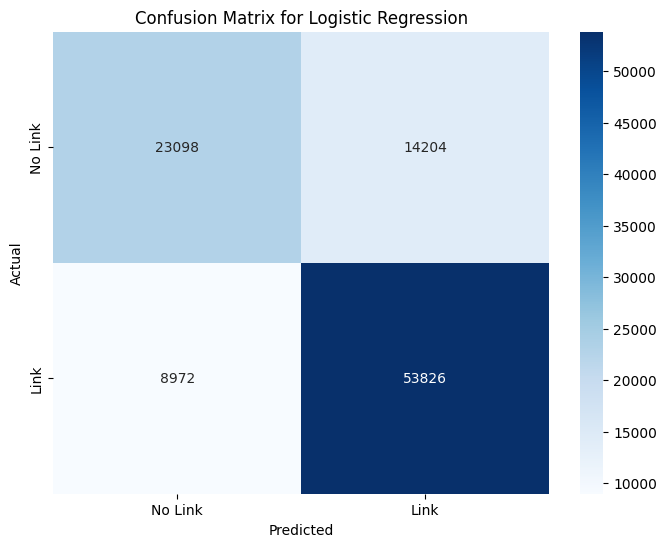

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

     No Link       0.72      0.62      0.67     37302
        Link       0.79      0.86      0.82     62798

    accuracy                           0.77    100100
   macro avg       0.76      0.74      0.74    100100
weighted avg       0.76      0.77      0.76    100100


Evaluating Decision Tree...

Decision Tree Test Accuracy: 0.99


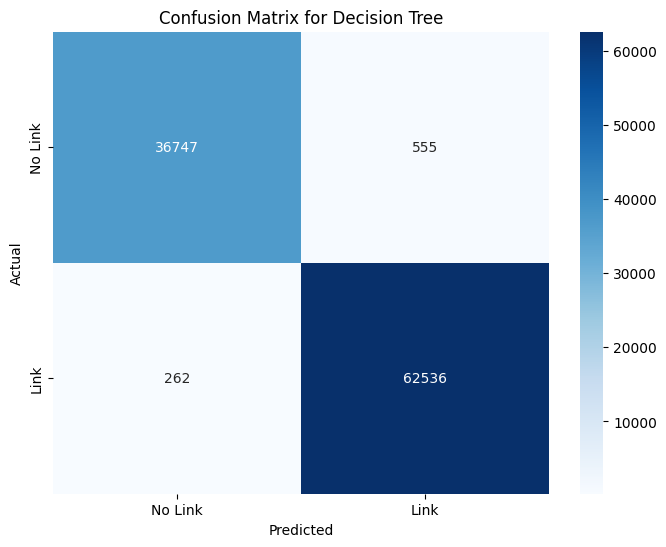

Classification Report for Decision Tree:
              precision    recall  f1-score   support

     No Link       0.99      0.99      0.99     37302
        Link       0.99      1.00      0.99     62798

    accuracy                           0.99    100100
   macro avg       0.99      0.99      0.99    100100
weighted avg       0.99      0.99      0.99    100100


Evaluating Random Forest...

Random Forest Test Accuracy: 0.99


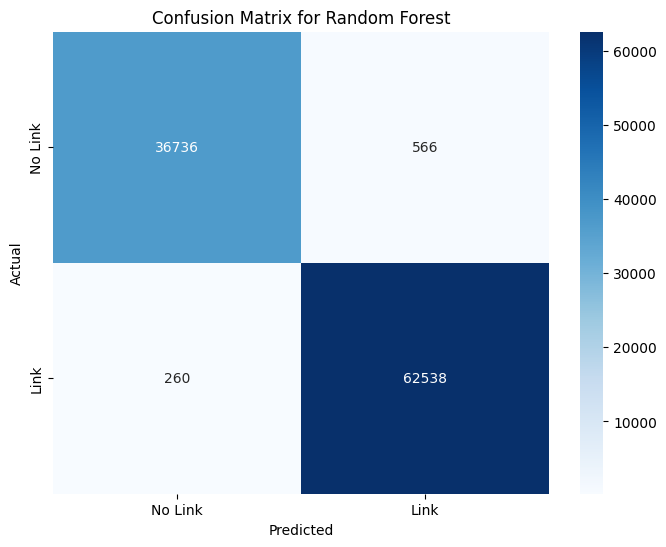

Classification Report for Random Forest:
              precision    recall  f1-score   support

     No Link       0.99      0.98      0.99     37302
        Link       0.99      1.00      0.99     62798

    accuracy                           0.99    100100
   macro avg       0.99      0.99      0.99    100100
weighted avg       0.99      0.99      0.99    100100


Evaluating Gradient Boosting...

Gradient Boosting Test Accuracy: 0.99


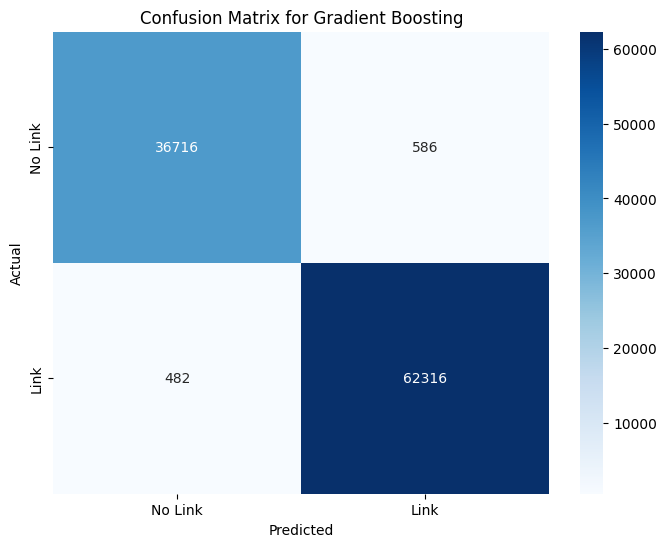

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

     No Link       0.99      0.98      0.99     37302
        Link       0.99      0.99      0.99     62798

    accuracy                           0.99    100100
   macro avg       0.99      0.99      0.99    100100
weighted avg       0.99      0.99      0.99    100100


Evaluating K-Nearest Neighbors...

K-Nearest Neighbors Test Accuracy: 0.99


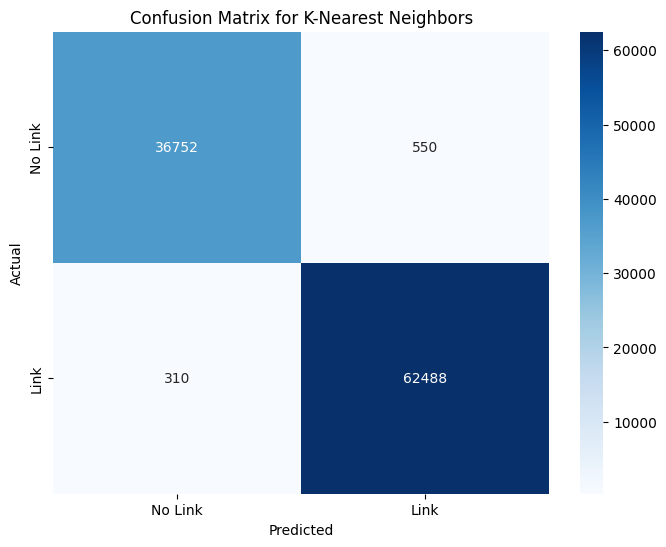

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

     No Link       0.99      0.99      0.99     37302
        Link       0.99      1.00      0.99     62798

    accuracy                           0.99    100100
   macro avg       0.99      0.99      0.99    100100
weighted avg       0.99      0.99      0.99    100100




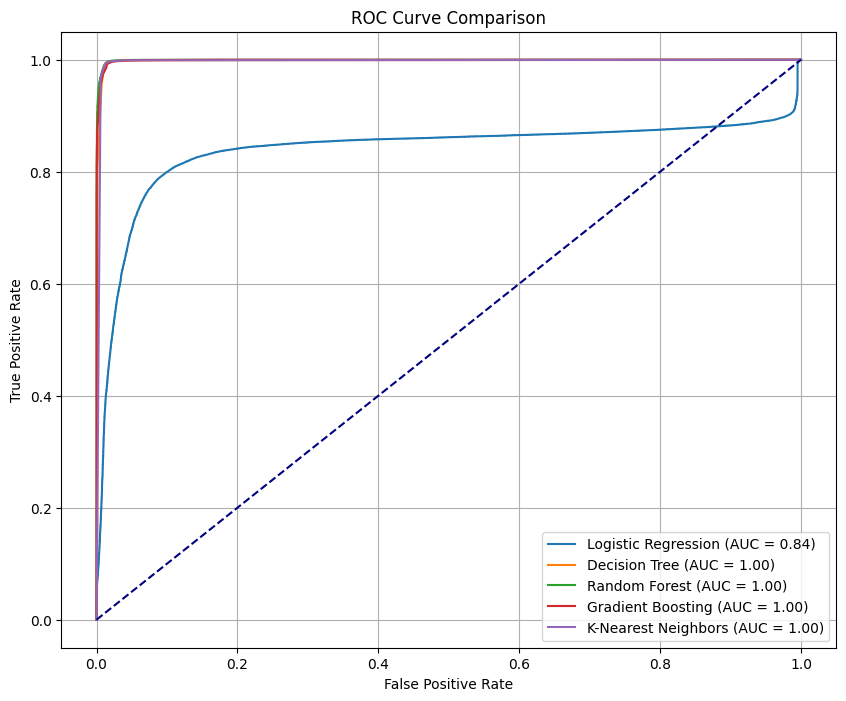

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=100),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Binarize the output for ROC curve (if necessary, adjust based on the problem)
y_test_binarized = label_binarize(y_test, classes=[0, 1])

# Dictionary to store ROC data for each model
roc_data = {}

# Loop through each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...\n")
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Test accuracy
    test_accuracy = model.score(X_test, y_test)
    print(f"{model_name} Test Accuracy: {test_accuracy:.2f}")
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Link', 'Link'], yticklabels=['No Link', 'Link'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=['No Link', 'Link'])
    print(f"Classification Report for {model_name}:\n{report}\n")
    
    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store ROC data
    roc_data[model_name] = (fpr, tpr, roc_auc)

# Plot ROC Curves for comparison
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()
